# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import pathlib
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable
%matplotlib inline

In [2]:
#If you use google collab put dataset in your gdrive and run this code
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


it is desirable to run model on gpu

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
#Color codes from label_colors.txt
color_codes = dict({
                'Animal': [64, 128, 64],
                'Archway': [192, 0, 128],
                'Bicyclist': [0, 128, 192],
                'Bridge': [0, 128, 64],
                'Building': [128, 0, 0],
                'Car': [64, 0, 128],
                'CartLuggagePram': [64, 0, 192],
                'Child': [192, 128, 64], 
                'Column_Pole': [192, 192, 128],
                'Fence': [64, 64, 128],
                'LaneMkgsDriv': [128, 0, 192],
                'LaneMkgsNonDriv': [192, 0, 64],
                'Misc_Text': [128, 128, 64],
                'MotorcycleScooter': [192, 0, 192],
                'OtherMoving': [128, 64, 64],
                'ParkingBlock': [64, 192, 128],
                'Pedestrian': [64, 64, 0],
                'Road': [128, 64, 128],
                'RoadShoulder': [128, 128, 192],
                'Sidewalk': [0, 0, 192],
                'SignSymbol': [192, 128, 128],
                'Sky': [128, 128, 128],
                'SUVPickupTruck': [64, 128, 192],
                'TrafficCone': [0, 0, 64],
                'TrafficLight': [0, 64, 64],
                'Train': [192, 64, 128],
                'Tree': [128, 128, 0],
                'Truck_Bus': [192, 128, 192],
                'Tunnel': [64, 0, 64],
                'VegetationMisc': [192, 192, 0],
                'Void': [0, 0, 0],
                'Wall': [64, 192, 0]
})

# Dataset from files

In [5]:
class video_recorder_dataset(Dataset):
  def __init__(self, dataset_dir, color_codes):
    super().__init__()
    self.dataset_dir = dataset_dir
    self.color_codes = color_codes

    self.images = [os.path.join(self.dataset_dir, x)for x in os.listdir(self.dataset_dir)]
    self.segment = sorted([x for x in self.images if '_L' in x])
    self.real = sorted([x for x in self.images if ('_L' not in x) and ('.txt' not in x)])
  
  def __len__(self):
    return len(self.real)

  # Creating segmentation mask from segmentation pictures
  def segment_channels(self, picture):
    seg_c = np.zeros((picture.shape[0], picture.shape[1]), dtype=np.int64)
    for i, colors in enumerate(self.color_codes.keys()):
      color = color_codes[colors]
      is_on_picture = np.all(picture==color, axis=-1) * i
      seg_c += is_on_picture
    return seg_c
  
  def __getitem__(self, index):
    real, segment = Image.open(self.real[index]), Image.open(self.segment[index])
    real, segment = np.array(real), np.array(segment)
    channels = self.segment_channels(segment)

    channels = channels.astype(np.float32)
    real = real.astype(np.float32) 

    sample = {'real': torch.from_numpy(real.transpose(2,0,1)),
              'channels': torch.from_numpy(channels)}
    
    return sample

In [6]:
dr = '/content/gdrive/MyDrive/dataset' # Paste your dataset directory
dataset = video_recorder_dataset(dr, color_codes)

In [7]:
train_size = int(len(dataset)*0.85)
train_set, val_set = random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_set, batch_size=2, drop_last=True)
val_loader = DataLoader(val_set, batch_size=2, drop_last=True)

# DeepLabV3

In [8]:
num_classes = 32

In [9]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

# Train


In [ ]:
#skip this part if you have already downloaded weights

In [ ]:
def train_epoch(model, train_dataset, criterion, optimizer):
  model.train()
  loss_history = []

  for sample in tqdm(train_dataset):
    x_batch = sample['real'].to(device)
    y_batch = sample['channels'].to(device)
    optimizer.zero_grad()
    outp = model(x_batch)
    y_pred = outp['out'] #model output it's OrderedDict with 'out' and 'aux' keys
    loss = criterion(y_pred, y_batch.long())
    loss.backward()
    loss_history.append(loss)
    optimizer.step()

  to_print = torch.mean(torch.Tensor(loss_history))
  print('Train loss:', to_print)
  return to_print.numpy()

In [ ]:
def test_epoch(model, test_dataset, criterion):
  model.eval()
  loss_history = []
  for sample in tqdm(test_dataset):
    x_batch = sample['real'].to(device)
    y_batch = sample['channels'].to(device)

    with torch.no_grad():
      outp = model(x_batch)

    y_pred = outp['out']
    loss = criterion(y_pred, y_batch.long())
    loss_history.append(loss)
    
  to_print = torch.mean(torch.Tensor(loss_history))
  print('val loss:', to_print)
  return to_print.numpy()



In [ ]:
def train(model, train_dataset, test_dataset, criterion, optimizer, epoch = 10):
  model.to(device)
  best_loss = 100

  for i in range(epoch):
    print('Epoch {0}/{1}'.format(i + 1, epoch))
    train_loss = train_epoch(model, train_dataset, criterion, optimizer)
    val_loss = test_epoch(model, test_dataset, criterion)
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = model.state_dict()

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, val_loader, criterion, optimizer)

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/segmentation.pth')

# Model test

In [ ]:
path = '/content/gdrive/MyDrive/segmentation.pth' # Paste your deeplabv3 weights directory
model.load_state_dict(torch.load(path))
model.to(device)

In [60]:
model.eval()
for img in val_loader:
    image = model(img['real'].to(device))['out']
    break

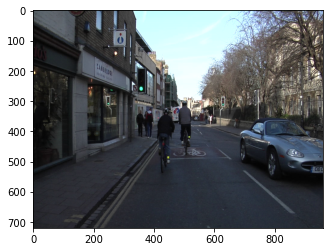

In [61]:
plt.imshow(img['real'][0].cpu().permute(1,2,0).numpy().astype(np.uint8));

In [62]:
def segment_show(image):
  fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(16,20)) 
  axes_list = [item for sublist in axes for item in sublist]

  thresh=0.7
  res = image.detach().cpu().numpy()
  for i, mask in enumerate(res):
      ax = axes_list.pop(0)
      ax.imshow(np.where(mask>thresh, 255, 0), cmap='gray')
      ax.set_title(list(color_codes.keys())[i])

  for ax in axes_list: 
      ax.remove()
      
  plt.tight_layout()

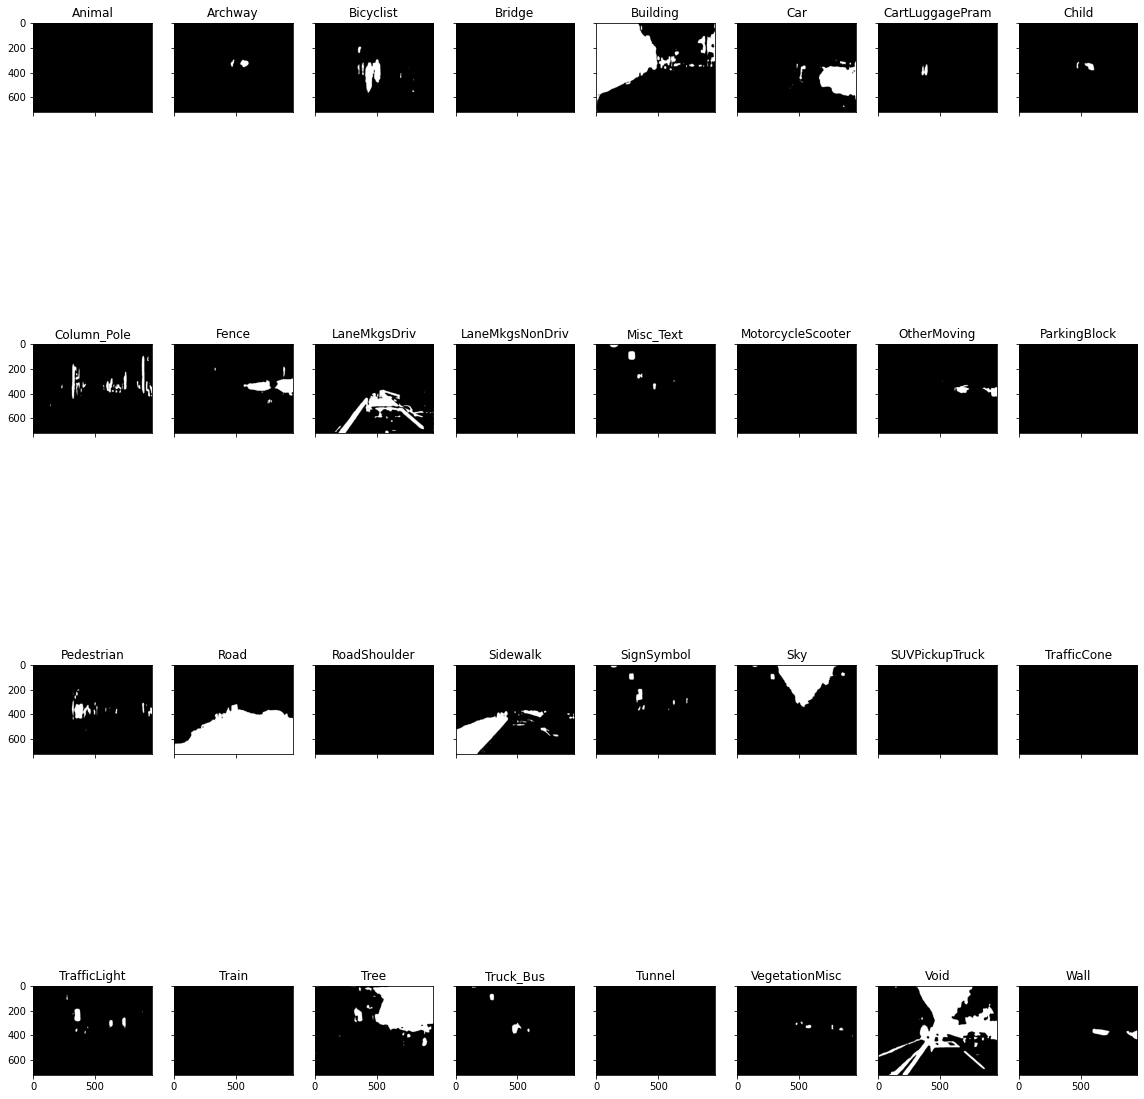

In [64]:
segment_show(image[0])